In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

from google.colab import files
uploaded = files.upload()

Saving viettri_quality.csv to viettri_quality.csv


In [3]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('viettri_quality.csv')
df1=df.reset_index()['pm25']

df1.shape

(1920,)

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

df1.shape

(1920, 1)

In [5]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

print(train_size)
print(test_size)

1728
192


In [6]:
print(train_data.shape)
print(test_data.shape)

(1728, 1)
(192, 1)


In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(ytest.shape)


(1627, 100)
(1627,)
(91, 100)
(91,)


In [11]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print(X_train.shape)
print(X_test.shape)

(1627, 100, 1)
(91, 100, 1)


In [13]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 13s 248ms/step - loss: 0.0338 - val_loss: 0.0146
Epoch 2/100
26/26 [==============================] - 6s 233ms/step - loss: 0.0241 - val_loss: 0.0136
Epoch 3/100
26/26 [==============================] - 6s 252ms/step - loss: 0.0237 - val_loss: 0.0153
Epoch 4/100
26/26 [==============================] - 10s 403ms/step - loss: 0.0243 - val_loss: 0.0136
Epoch 5/100
26/26 [==============================] - 10s 383ms/step - loss: 0.0230 - val_loss: 0.0136
Epoch 6/100
26/26 [==============================] - 6s 231ms/step - loss: 0.0232 - val_loss: 0.0138
Epoch 7/100
26/26 [==============================] - 4s 164ms/step - loss: 0.0230 - val_loss: 0.0137
Epoch 8/100
26/26 [==============================] - 8s 307ms/step - loss: 0.0226 - val_loss: 0.0138
Epoch 9/100
26/26 [==============================] - 4s 164ms/step - loss: 0.0225 - val_loss: 0.0133
Epoch 10/100
26/26 [==============================] - 6s 218ms/step - loss: 0.0225 - val

In [14]:
X_test.shape

(91, 100, 1)

In [15]:
# 10. Dự báo dữ liệu test,
train_predict=model.predict(X_train)
y_pred=model.predict(test_data.reshape(test_data.shape[0],test_data.shape[1] , 1))


6/6 [==============================] - 2s 4ms/step


In [16]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [17]:
print(test_data.shape)
print(y_pred.shape)

(192, 1)
(192, 1)


In [18]:
ytest=scaler.inverse_transform(test_data)
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

# Đánh giá độ chính xác thuật toán bằng MAPE
test_mape = np.mean(np.abs(ytest - y_pred)/np.abs(ytest))*100

print('Testing MAPE:', test_mape)

# Đánh giá độ chính xác thuật toán bằng MAE
test_mae = np.mean(abs(y_pred - ytest))
print('Testing MAE:', test_mae)

Testing RMSE: 30.381244315221696
Testing MAPE: 59.35353186516842
Testing MAE: 25.16492835680644


In [19]:
x_input=test_data[60:].reshape(1,-1)
x_input.shape

(1, 132)

In [20]:
# 13. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
print(x_input.shape)

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=132
i=0
while(i<90):

    if(len(temp_input)>132):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


(1, 132)
[0.12392095]
133
1 day input [0.         0.29378531 0.29943503 0.32768362 0.35028249 0.24858757
 0.28248588 0.38418079 0.21468927 0.17514124 0.25988701 0.32768362
 0.27683616 0.31638418 0.44067797 0.36158192 0.13559322 0.13559322
 0.29378531 0.13559322 0.26553672 0.27118644 0.24293785 0.2259887
 0.40677966 0.36158192 0.28248588 0.27683616 0.42372881 0.38983051
 0.28813559 0.27683616 0.07909605 0.07909605 0.16949153 0.08474576
 0.20338983 0.11864407 0.10734463 0.19774011 0.45762712 0.36723164
 0.4519774  0.61581921 0.42937853 0.6440678  0.59887006 0.16949153
 0.13559322 0.39548023 0.36723164 0.13559322 0.32768362 0.3559322
 0.44067797 0.3559322  0.16384181 0.13559322 0.28813559 0.47457627
 0.32768362 0.31638418 0.30508475 0.25988701 0.42372881 0.28813559
 0.23728814 0.30508475 0.4180791  0.46327684 0.36158192 0.38983051
 0.43502825 0.28813559 0.23728814 0.28248588 0.1299435  0.16949153
 0.4180791  0.40112994 0.29943503 0.25988701 0.33898305 0.33333333
 0.23163842 0.30508475 0.3

In [21]:
print(x_input.shape)
print(test_data.shape)

(1, 132, 1)
(192, 1)


In [22]:
test_data.shape

(192, 1)

In [23]:
y_pred.shape

(192, 1)

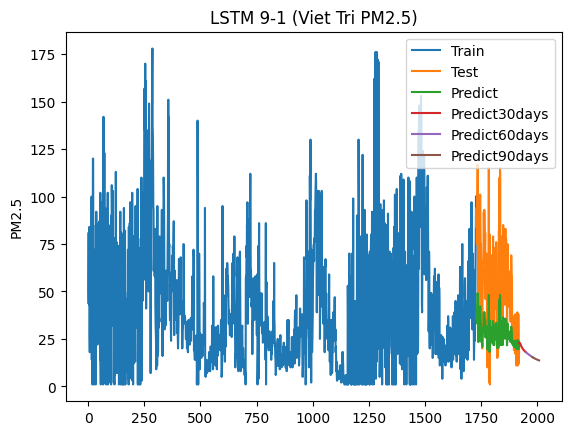

In [24]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,y_pred)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Train','Test','Predict','Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 9-1 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()

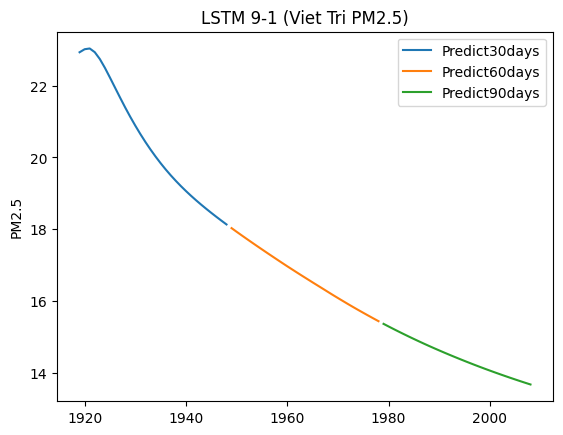

In [25]:
# 14.Vẽ hình
# Dự đoán 90 ngày tiếp theo

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[0:30]))

prediect_data_index = pd.RangeIndex(start=len(df1)+29, stop=len(df1)+59, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[30:60]))

prediect_data_index = pd.RangeIndex(start=len(df1)+59, stop=len(df1)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output[60:90]))
plt.legend(['Predict30days', 'Predict60days', 'Predict90days'])
plt.title('LSTM 9-1 (Viet Tri PM2.5)')
plt.ylabel('PM2.5')
plt.show()

In [26]:
print(scaler.inverse_transform(lst_output))

[[22.93400767]
 [23.01836038]
 [23.03943141]
 [22.93593833]
 [22.74456884]
 [22.49937314]
 [22.2268265 ]
 [21.94663374]
 [21.66738257]
 [21.39436382]
 [21.13381784]
 [20.88637234]
 [20.65170293]
 [20.42979376]
 [20.22101673]
 [20.02441444]
 [19.83883691]
 [19.66429207]
 [19.50042912]
 [19.34619044]
 [19.20013066]
 [19.0618858 ]
 [18.93013713]
 [18.80411711]
 [18.68316375]
 [18.56663348]
 [18.45343702]
 [18.34335017]
 [18.23599842]
 [18.1309624 ]
 [18.02780956]
 [17.9262656 ]
 [17.82600874]
 [17.72695985]
 [17.62858354]
 [17.53119364]
 [17.43492205]
 [17.3391173 ]
 [17.24440975]
 [17.14994881]
 [17.05598636]
 [16.963071  ]
 [16.87224454]
 [16.78143258]
 [16.69160706]
 [16.60314512]
 [16.51406865]
 [16.42649555]
 [16.33913346]
 [16.25068471]
 [16.16298501]
 [16.07735048]
 [15.99273667]
 [15.90850925]
 [15.82612281]
 [15.74507622]
 [15.66550927]
 [15.58692743]
 [15.50907486]
 [15.43240125]
 [15.35741434]
 [15.28419982]
 [15.21190579]
 [15.14082238]
 [15.07094035]
 [15.00218058]
 [14.93497